# 1. Introduction

This notebook outlines the creation, compilation, and training of a deep learing network for audio classification using the [TorchSuite](https://github.com/sergio-sanz-rodriguez/torchsuite) framework.
 
https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

# 2. Importing Libraries

In [1]:
#!pip install torcheval
import os
import shutil
import torch
import glob
import random
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR, ConstantLR, SequentialLR, StepLR
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import Resample

# Import custom libraries
from utils.classification_utils import predict_and_play_audio
from utils.common_utils import set_seeds, load_model
from engines.classification import ClassificationEngine
from engines.schedulers import FixedLRSchedulerWrapper
from dataloaders.audio_dataloaders import load_audio, create_dataloaders_waveform, AudioWaveformTransforms
from models.wav2vec2 import Wav2Vec2Classifier

import warnings
os.environ['TORCH_USE_CUDA_DSA'] = "1"
warnings.filterwarnings("ignore", category=UserWarning, module="torch.autograd.graph")
warnings.filterwarnings("ignore", category=FutureWarning, module="onnxscript.converter")

# Paths (modify as needed)
TARGET_DIR_NAME = Path("data/SpeechCommands/speech_commands_v0.02")
TRAIN_DIR = Path("data/SpeechCommands/train")
TEST_DIR = Path("data/SpeechCommands/test")

# Define some constants
NUM_WORKERS = os.cpu_count()
SEED = 42

# Create target model directory
MODEL_DIR = Path("outputs")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Set seeds
set_seeds(SEED)

IMPORT_DATASET = False

# 3. Specifying the Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Thu Oct 30 20:41:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   41C    P8              9W /  200W |    1019MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Importing Dataset

The dataset should be organized as follows, with one subdirectory per class containing the corresponding images:

```
dataset/
├── train/
│   └── <class_label>/
│       ├── img1.jpg
│       ├── img2.png
│       └── ...
└── test/ (or val/)/
    └── <class_label>/
        ├── img1.jpg
        ├── img2.png
        └── ...
```

In [3]:
if IMPORT_DATASET:
    # Download dataset
    os.makedirs("data", exist_ok=True)
    dataset = SPEECHCOMMANDS(
        root="./data",
        url="speech_commands_v0.02",
        folder_in_archive="SpeechCommands",
        download=True,
        subset=None
        )

In [4]:
if IMPORT_DATASET:
    # Read validation and test lists
    val_test_files = set()
    for filename in ["validation_list.txt", "testing_list.txt"]:
        with open(os.path.join(TARGET_DIR_NAME, filename), "r") as f:
            val_test_files.update(f.read().splitlines())

    # Ensure output directories exist
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    # Loop over all class folders
    for class_name in os.listdir(TARGET_DIR_NAME):
        class_path = os.path.join(TARGET_DIR_NAME, class_name)
        if not os.path.isdir(class_path):  # Skip non-folder files
            continue

        # Create class folders in train/ and test/
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

        # Loop over all audio files in the class folder
        for file_name in os.listdir(class_path):
            # Skip non-wav-audio files
            if not file_name.endswith(".wav"):  
                continue
            
            # Copy file to train/ or test/
            src_path = os.path.join(class_path, file_name)
            dest_folder = TEST_DIR if f"{class_name}/{file_name}" in val_test_files else TRAIN_DIR
            dest_path = os.path.join(dest_folder, class_name)        
            shutil.copy(src_path, dest_path)

    # Remove _background_noise_ (not needed for this notebook)
    background_noise_train = TRAIN_DIR / "_background_noise_"
    background_noise_test = TEST_DIR / "_background_noise_"

    # Remove unnecessary folders and files
    if background_noise_train.exists():
        shutil.rmtree(background_noise_train)

    if background_noise_test.exists():
        shutil.rmtree(background_noise_test)

    if TARGET_DIR_NAME.exists():
        shutil.rmtree(TARGET_DIR_NAME)

    zip_file = Path("data/speech_commands_v0.02.tar.gz")
    if zip_file.exists():
        os.remove(zip_file)

    print("Dataset restructuring completed!")

# 5. Preparing Dataloaders

In [5]:
new_sample_rate = 8000
target_length = 8000 # use 1-sec length
waveform, sample_rate = load_audio('data/SpeechCommands/train/backward/0a2b400e_nohash_0.wav')
BATCH_SIZE = 64
THEME = 'dark' # or 'dark'. Default is 'light'

# Transformations for training dataset
get_transform_train = AudioWaveformTransforms(
    augmentation=True,
    sample_rate=sample_rate,
    new_sample_rate=new_sample_rate,
    target_length=target_length,
    seed=SEED,
    augment_magnitude=2
)

# Transformations for test dataset
get_transform_test = AudioWaveformTransforms(
    augmentation=False,   
    sample_rate=sample_rate,
    new_sample_rate=new_sample_rate,
    target_length=target_length,
    seed=SEED,
    augment_magnitude=2
)

train_dataloader, test_dataloader, class_names = create_dataloaders_waveform(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=get_transform_train,
    test_transform=get_transform_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    random_seed=SEED
)

dataloaders = {
    'train': train_dataloader,
    'test':  test_dataloader
}

# Verify classes and batches
print(f"Classes: {class_names}")
print(f"Train batches: {len(train_dataloader)}, Test batches: {len(test_dataloader)}")

Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Train batches: 1326, Test batches: 328


In [6]:
# Calculate the number of classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 35


# 6. Audio Visualization and Reproduction

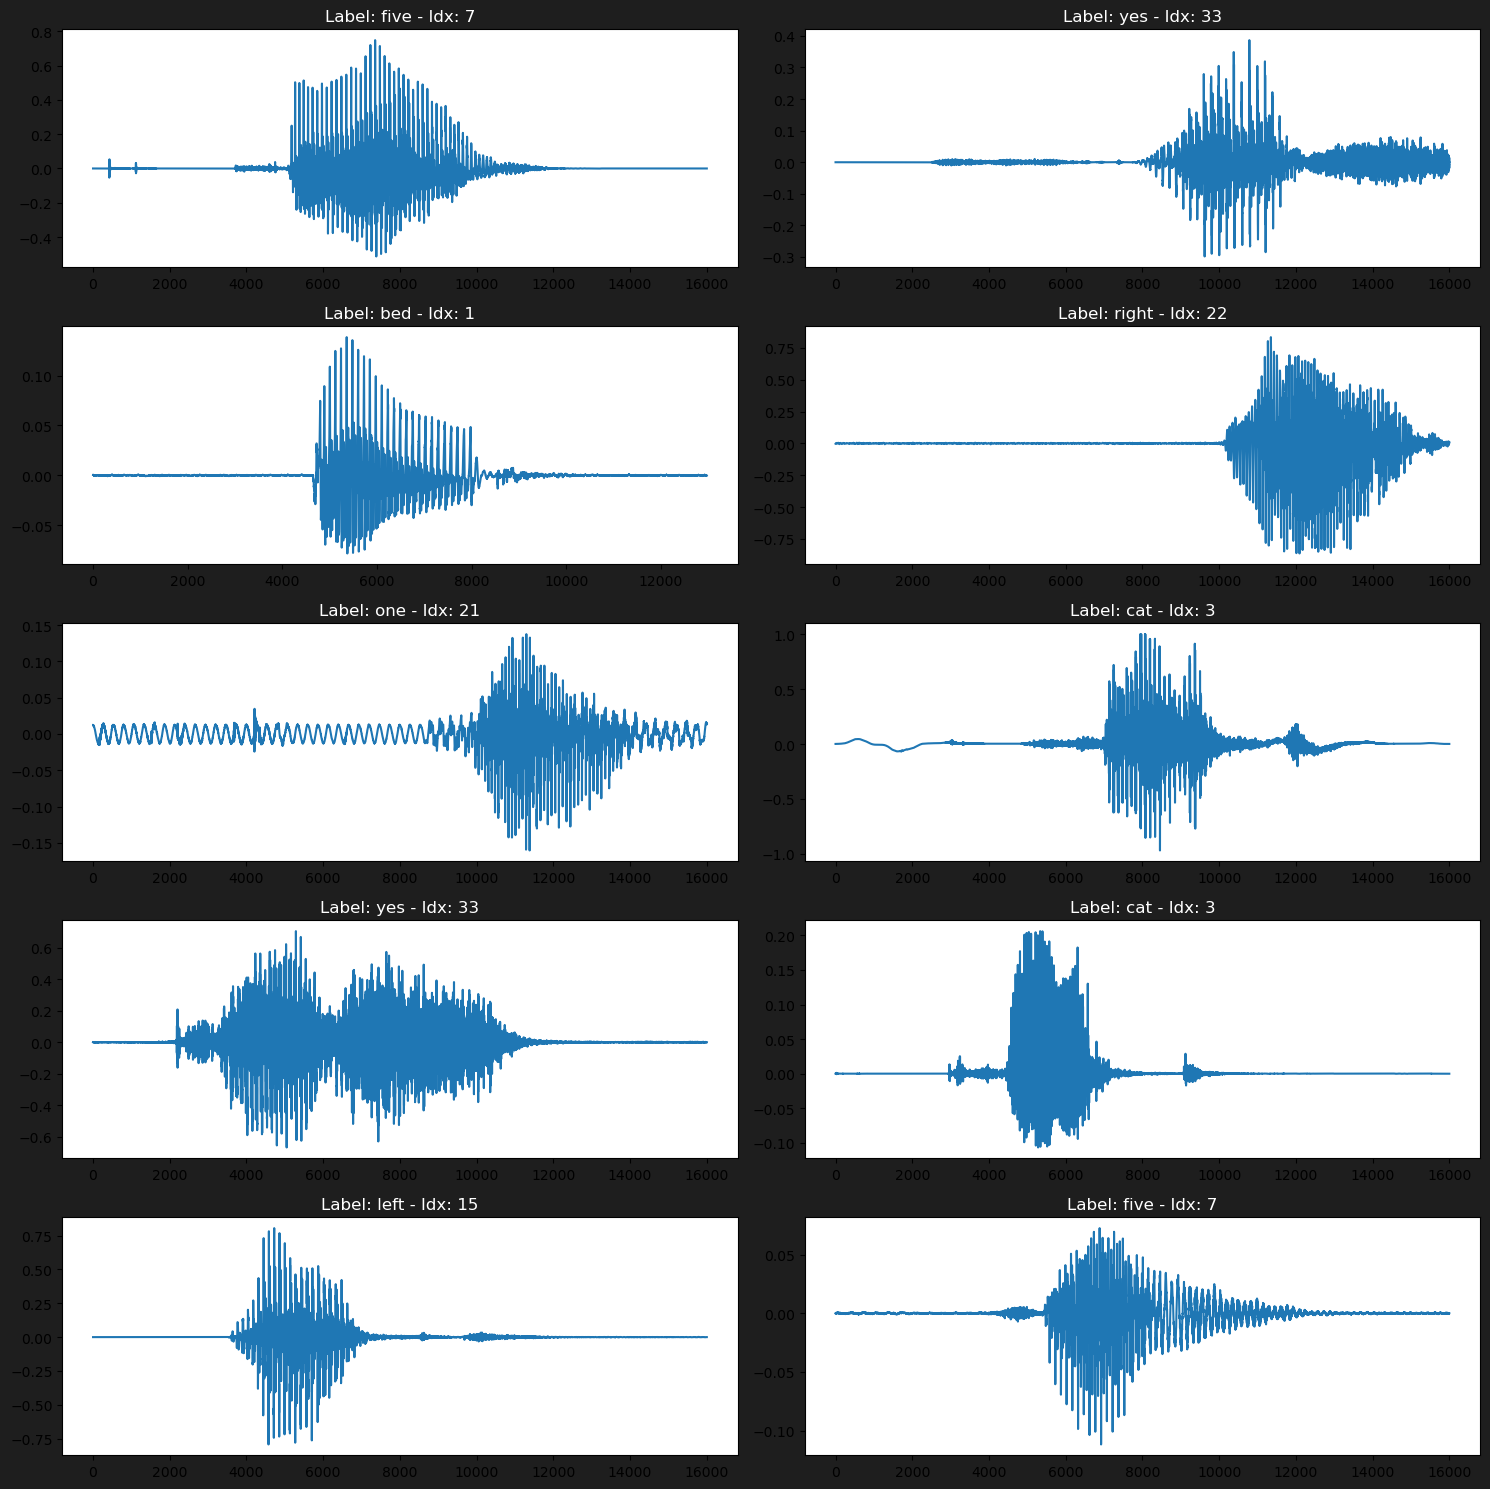

In [7]:
# Get the length of the train_set
train_set_size = len(train_dataloader.dataset)

# Visualize some audio waveforms
theme_presets = {
    "light": {"bg": "white", "text": "black"},
    "dark": {"bg": "#1e1e1e", "text": "white"}
}
figure_color_map = theme_presets[THEME]
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
fig.patch.set_facecolor(figure_color_map['bg'])
for col in range(2):
    for row in range(5):
        # Randomly select an index from the train_set
        idx = torch.randint(0, train_set_size, (1,)).item()
        
        # Get the waveform, sample rate, and label for the selected index
        try:
            waveform, _ = load_audio(train_dataloader.dataset.files[idx])
            label = class_names[train_dataloader.dataset.labels[idx]]
            
            # Plot the waveform
            axs[row][col].plot(waveform.t().numpy())  # Ensure the waveform is transposed if necessary
            axs[row][col].set_title(f"Label: {label} - Idx: {train_dataloader.dataset.labels[idx]}", color=figure_color_map['text'])  # Set the label as the title
        except:
            waveform, _ = load_audio(train_dataloader.dataset.dataset.files[idx])
            label = class_names[train_dataloader.dataset.dataset.labels[idx]]        
        
            # Plot the waveform
            axs[row][col].plot(waveform.t().numpy())  # Ensure the waveform is transposed if necessary
            axs[row][col].set_title(f"Label: {label} - Idx: {train_dataloader.dataset.dataset.labels[idx]}", color=figure_color_map['text'])  # Set the label as the title

fig.tight_layout()
plt.show()

In [8]:
# Play out some audio files
try:
    waveform_first, _ = load_audio(train_dataloader.dataset.files[0])
except:
    waveform_first, _ = load_audio(train_dataloader.dataset.dataset.files[0])
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [9]:
try:
    waveform_second, *_ = load_audio(train_dataloader.dataset.files[1])
except:
    waveform_second, *_ = load_audio(train_dataloader.dataset.dataset.files[1])
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

# 7. Creating the Model

In [10]:
# Define a custom model
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.squeeze(-1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)    

CUSTOM_MODEL = 2

# Instatiate the model
if CUSTOM_MODEL == 1:
    in_channels = load_audio(train_dataloader.dataset.files[0])[0].shape[0]
    model = M5(n_input=in_channels, n_output=num_classes)
    LR = 0.01
    ETA_MIN = 1e-5
    EPOCHS = 25
else:
    model = Wav2Vec2Classifier(
        base_model_name="facebook/wav2vec2-base",
        num_classes=num_classes)
    LR = 1e-5
    ETA_MIN = 1e-7
    EPOCHS = 25

# Unfreeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = True

# Compile model (optional)
#model = torch.compile(model, backend="aot_eager")

# Send model to device
model.to(device)

# Print the summary of the model
summary(model,
        input_size=(BATCH_SIZE, 16000),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
Wav2Vec2Classifier (Wav2Vec2Classifier)                                [64, 16000]          [64, 35]             --                   True
├─Wav2Vec2Model (wav2vec2)                                             [64, 16000]          [64, 49, 512]        768                  True
│    └─Wav2Vec2FeatureEncoder (feature_extractor)                      [64, 16000]          [64, 512, 49]        --                   True
│    │    └─ModuleList (conv_layers)                                   --                   --                   4,200,448            True
│    └─Wav2Vec2FeatureProjection (feature_projection)                  [64, 49, 512]        [64, 49, 768]        --                   True
│    │    └─LayerNorm (layer_norm)                                     [64, 49, 512]        [64, 49, 512]        1,024                True
│    │    └─Linear (pr

# 8. Training the Model

In [ ]:
# Train the model
model_type="model_waveform"
model_name = model_type + ".pth"

# Create AdamW optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    weight_decay=0.0001
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # Reduces LR by a constant factor
cosine = CosineAnnealingLR(optimizer, T_max=EPOCHS-5, eta_min=ETA_MIN) # 1-20:  LR = 1e-5 -> 1e-7 (cosine)
fixed = ConstantLR(optimizer, factor=ETA_MIN/LR, total_iters=5)        # 20-25: LR = 1e-6
scheduler = SequentialLR(
    optimizer,
    schedulers=[cosine, fixed],
    milestones=[20] 
)

# Alternative is this custom class:
#scheduler = FixedLRSchedulerWrapper(
#    scheduler=CosineAnnealingLR(optimizer, T_max=EPOCHS-5, eta_min=ETA_MIN),
#    fixed_lr=ETA_MIN,
#    fixed_epoch=EPOCHS-5)

# And train...

# Instantiate the classification engine with the created model and the target device
engine = ClassificationEngine(
    model=model,                                # Model to be trained
    optimizer=optimizer,                        # Optimizer
    loss_fn=loss_fn,                            # Loss function
    scheduler=scheduler,                        # Scheduler 
    use_distillation=False,                     # Optional, use_distillation is False by default    
    log_verbose=True,                           # Verbosity
    theme=THEME,                                # Theme (default is 'light')
    device=device                               # Target device
    )

# Configure the training method
results = engine.train(
    target_dir=MODEL_DIR,                       # Directory where the model will be saved
    model_name=model_name,                      # Name of the model
    enable_resume=True,                         # Resume training from the last saved checkpoint
    save_best_model=["last", "loss", "acc"],    # Save the best models based on different criteria
    keep_best_models_in_memory=False,           # If False: do not keep the models stored in memory for the sake of training time and memory efficiency
    dataloaders=dataloaders,                    # Dictionary with the dataloaders     
    apply_validation=True,                      # Enable validation step
    augmentation_strategy="always",             # Augmentation strategy    
    recall_threshold=1.0,                       # False positive rate at recall_threshold recall
    recall_threshold_pauc=0.0,                  # Partial AUC score above recall_threshold_pauc recall
    epochs=EPOCHS,                              # Total number of epochs
    amp=True,                                   # Enable Automatic Mixed Precision (AMP)
    enable_clipping=False,                      # Disable clipping on gradients, only useful if training becomes unestable
    debug_mode=False,                           # Disable debug mode    
    accumulation_steps=1,                       # Accumulation steps 2: effective batch size = batch_size x accumulation steps
    )

Epoch: 4/25 | Train | loss: 2.1473 | acc: 0.4782 | f1: 0.4489 | fpr: 0.9155 | pauc: 0.9339 | time:   4m46s | lr: 0.0000094605
Epoch: 4/25 | Test  | loss: 1.2106 | acc: 0.8240 | f1: 0.7998 | fpr: 0.6046 | pauc: 0.9888 | time:   1m53s | lr: 0.0000094605
[INFO] Verification complete! Training continues.


  0%|          | 0/1326 [00:00<?, ?it/s]

In [ ]:
# Make predictions by manually loading the last-epoch model manually
engine2 = ClassificationEngine(
        model=Wav2Vec2Classifier(num_classes=num_classes),
        log_verbose=False,
        device=device)

# Find the file that matchs the pattern `model_acc`
model_file = glob.glob(os.path.join(MODEL_DIR, "model_waveform_acc_*.pth"))
model_name = os.path.basename(model_file[0])
engine2.load(target_dir=MODEL_DIR, model_name=model_name)
indexes2 = engine2.predict(
    dataloader=test_dataloader,
    output_type='argmax').tolist()

In [ ]:
# Load now the model and assign it to `model`
model = Wav2Vec2Classifier(num_classes=num_classes)
#model = torch.compile(model, backend="aot_eager")
model = load_model(model, MODEL_DIR, model_name)
model.to(device)

In [ ]:
# Get 24 random indexes from the test dataset
num_samples = 24
random_indices = random.sample(range(len(test_dataloader.dataset)), num_samples)

# Load audio files and get predictions
waveform_list = []
label_list = []
sample_rate_list = []
for idx in random_indices:
    
    # Load waveform and label
    try:
        waveform, sample_rate = load_audio(test_dataloader.dataset.files[idx])
        actual_label = class_names[test_dataloader.dataset.labels[idx]]
    except:
        waveform, sample_rate = load_audio(test_dataloader.dataset.dataset.files[idx])
        actual_label = class_names[test_dataloader.dataset.dataset.labels[idx]]

    # Append data
    waveform_list.append(waveform)
    label_list.append(actual_label)
    sample_rate_list.append(sample_rate)

# Predict and play back
predict_and_play_audio(
    model=model,
    waveform_list=waveform_list,
    label_list=label_list,
    sample_rate_list=sample_rate_list,
    class_names=class_names,
    transform=get_transform_test,
    device=device
)

In [ ]:
# Generate a classification report 
pred_list, classif_report = engine2.predict_and_store(
    test_dir=TEST_DIR,
    transform=get_transform_test,
    class_names=class_names,
    sample_fraction=1,
    seed=SEED)

In [ ]:
pd.DataFrame(classif_report)

In [ ]:
speed = round(1.0 / pd.DataFrame(pred_list)['time_for_pred'].mean(), 2)
print(f'GPU: Predicted Images per Sec [fps]: {speed}')